In [68]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import nbimporter
from src import Gaussian_Filter

In [69]:
lena = Image.open('lena_color.tiff')

In [70]:
lenarr = np.array(lena)
kernel = np.array([[2, 4, 5, 4, 2],[4, 9, 12, 9, 4],[5, 12, 15, 12, 5], [4, 9, 12, 9, 4], [2, 4, 5, 4, 2]])
gauss_lena = Gaussian_Filter.gaussian_blur(lenarr, kernel)
lenarr_gray = np.sum(lenarr, axis=2)/3

In [71]:
def gradients(im): #sobel-feldman
    x_ker = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    y_ker = x_ker.T
    gradient_x = np.zeros((im.shape[0], im.shape[1]))#, im.shape[2])) #np.copy(im) ##zeros result in a black border, copy in 2 pixels unblurred
    gradient_y = np.zeros((im.shape[0], im.shape[1]))#, im.shape[2]))
    
    for i in range(1, im.shape[0]-1):
        for j in range(1, im.shape[1]-1):
            gradient_x[i, j] = np.floor(np.sum(np.multiply(x_ker,im[i-1:i+2, j-1:j+2]))) 
            gradient_y[i, j] = np.floor(np.sum(np.multiply(y_ker,im[i-1:i+2, j-1:j+2]))) 

    return gradient_x, gradient_y

In [72]:
g_x_lena, g_y_lena = gradients(lenarr_gray)

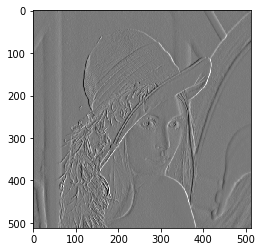

In [73]:
plt.imshow(g_x_lena.astype(int), cmap='gray')

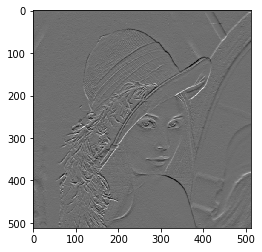

In [74]:
plt.imshow(g_y_lena.astype(int), cmap='gray')

In [75]:
def g_mag(G_x, G_y):
    return np.sqrt(np.square(G_x)+ np.square(G_y))

In [76]:
def gradient(im):
    G_x, G_y = gradients(im)
    return g_mag(G_x.flatten(), G_y.flatten()).reshape(G_x.shape)

In [77]:
g_lena = gradient(lenarr_gray)
print(g_lena.shape)

(512, 512)


In [78]:
Theta = np.arctan2(g_x_lena, g_y_lena)
print(Theta.shape)

(512, 512)


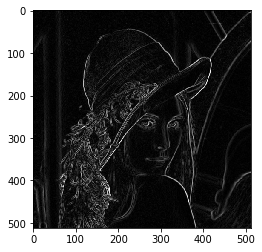

In [79]:
plt.imshow(g_lena.astype(int), cmap='gray')
plt.imsave("gradient_lena.png", g_lena)

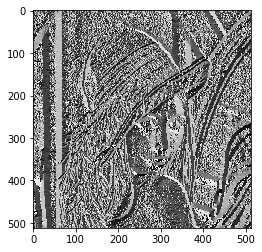

In [80]:
plt.imshow(Theta, cmap='gray')

In [81]:
def directions(im):
    F_vrt = np.array([[0,1,0],[0,0,0],[0,1,0]])
    F_dwn = np.array([[1,0,0],[0,0,0],[0,0,1]])
    F_hrz = np.array([[0,0,0],[1,0,1],[0,0,0]])
    F_upw = np.array([[0,0,1],[0,0,0],[1,0,0]])
    
    dir_vrt = np.zeros((im.shape[0], im.shape[1]))
    dir_dwn = np.zeros((im.shape[0], im.shape[1]))
    dir_hrz = np.zeros((im.shape[0], im.shape[1]))
    dir_upw = np.zeros((im.shape[0], im.shape[1]))
    
    for i in range(1, im.shape[0]-1):
        for j in range(1, im.shape[1]-1):
            dir_vrt[i, j] = (np.max(np.multiply(F_vrt,im[i-1:i+2, j-1:j+2]))) #calculted pixel value
            dir_dwn[i, j] = (np.max(np.multiply(F_dwn,im[i-1:i+2, j-1:j+2]))) 
            dir_hrz[i, j] = (np.max(np.multiply(F_hrz,im[i-1:i+2, j-1:j+2]))) 
            dir_upw[i, j] = (np.max(np.multiply(F_upw,im[i-1:i+2, j-1:j+2]))) 
            
    return dir_vrt, dir_dwn, dir_hrz, dir_upw

In [82]:
vrt_lena, dwn_lena, hrz_lena, upw_lena = directions(g_lena)
dir_lena = np.array((vrt_lena, upw_lena, hrz_lena, dwn_lena))

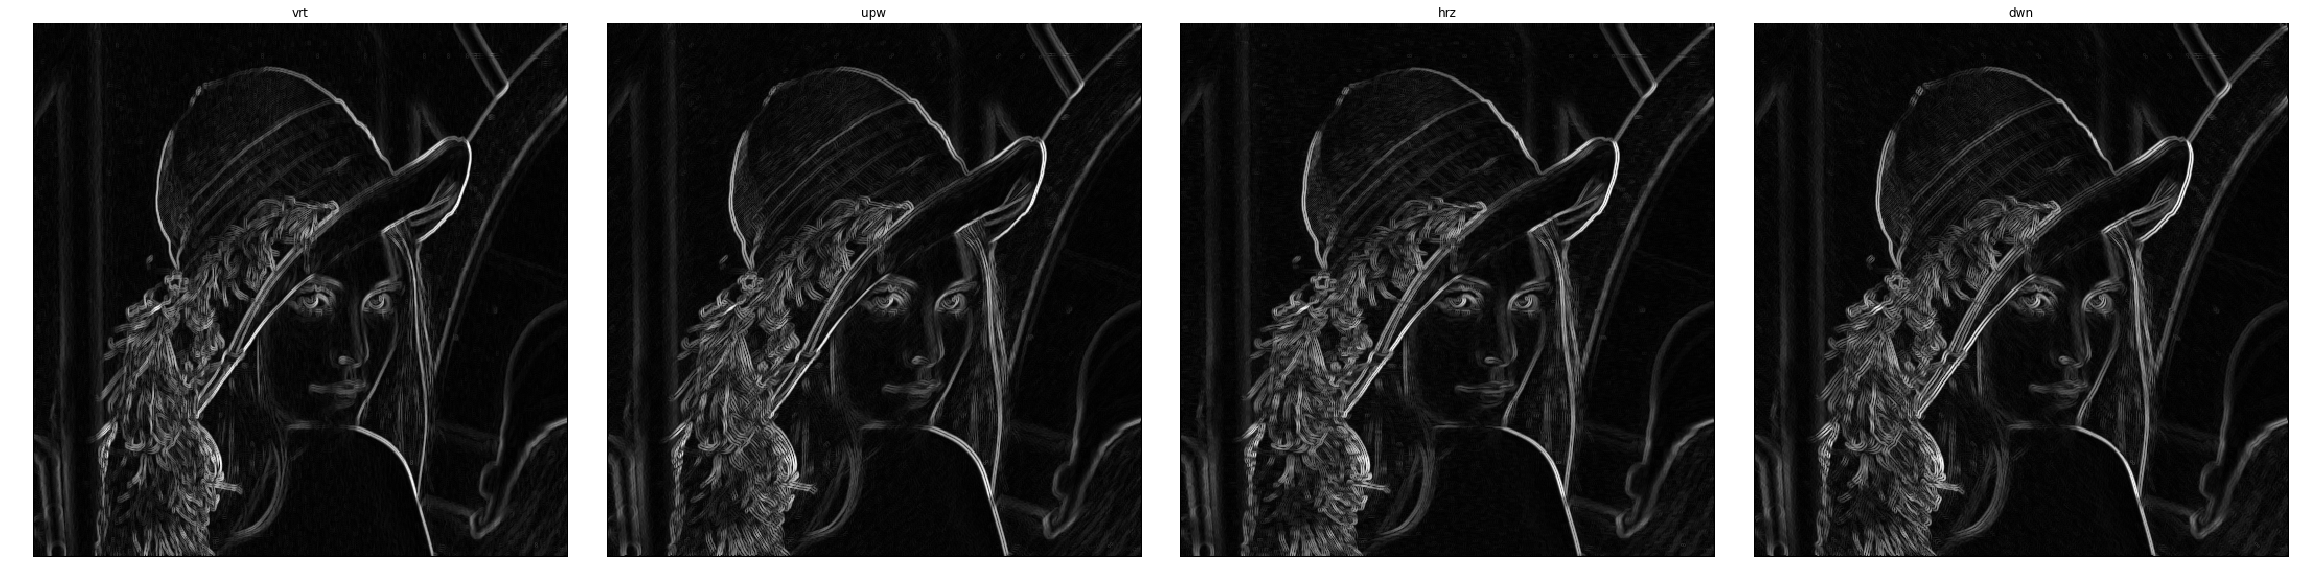

In [83]:
titles = ["vrt", "upw", "hrz", "dwn"]
fig, ax = plt.subplots(1, 4, figsize=(32,8))
plt.gray()
for i, axi in enumerate(ax.flat):
    axi.imshow(dir_lena[i].astype(int))
    axi.set_title(titles[i])
    axi.set_axis_off()

plt.tight_layout(True)
plt.show()

In [84]:
def discretize_theta(Theta):
    lb = -2*np.pi
    ub = lb + np.pi/2

    Theta_f = Theta.flatten()
    Theta_disc = np.zeros(Theta_f.shape)

    for i in range(8):
        #Theta_i = np.where((Theta >= lb), np.where(Theta < ub, i%4, 0), 0)
        #Theta_disc = Theta_disc + Theta_i
        for j in range(Theta_f.shape[0]):
            if Theta_f[j] >= lb and Theta_f[j] < ub:
                Theta_disc[j] = i%4
        lb = lb + np.pi/2
        ub = ub + np.pi/2
    return Theta_disc.reshape(Theta.shape).astype(int)

In [85]:
def non_maximum_suppression(G, D, Theta):
    mask = np.zeros(Theta.shape)

    for i in range(1, Theta.shape[0]-1):
        for j in range(1, Theta.shape[1]-1):
            if G[i, j] > np.max(D[Theta[i,j], i, j]):
                mask[i,j] = 1 # in the direction given by theta select the pixel i,j in D
        
    return mask

In [91]:
#Theta_disc = Theta_disc.reshape(g_lena.shape).astype(int)

Theta_disc = discretize_theta(Theta)

print(dir_lena.shape, g_lena.shape, Theta_disc.shape)

I = non_maximum_suppression(g_lena, dir_lena, Theta_disc)
print(I.shape)
I_lena = np.where(I,  g_lena, 0) #apply mask
print(I_lena.shape)

(4, 512, 512) (512, 512) (512, 512)
(512, 512)
(512, 512)


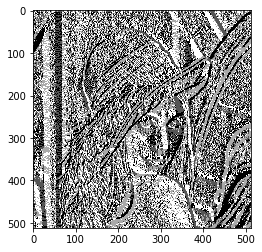

In [87]:
plt.imshow(Theta_disc)

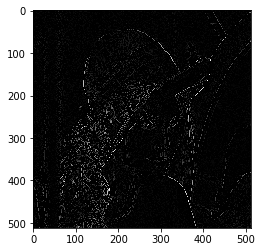

In [89]:
plt.imshow(I_lena, cmap='gray')
#Image.SAVE("gauss-non-maximum_supression_lena.tiff", I_lena)
plt.imsave("gauss-non-maximum_supression_lena.tiff", I_lena)

In [93]:
I_lena.shape
print(I_lena)

[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           7.           0.         ...  60.00833275 147.00340132
    0.        ]
 [  0.           7.           0.         ...   0.         147.00340132
    0.        ]
 ...
 [  0.           0.           0.         ...   0.          27.20294102
    0.        ]
 [  0.          35.22782991   0.         ...   0.          20.61552813
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
